In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
with open('data/new_files/get_movies.pkl', 'rb') as f:
    t = pickle.load(f)
    
movie_dic = t[0]
movie_genre_dic = t[1]

with open('data/new_files/get_ratings.pkl', 'rb') as f:
    lst = pickle.load(f)

In [3]:
def grad_A(Ui, Yij, Vj, a, b, y_mean, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the updated value of a (by updating by eta times the gradient with respect to a).
    """
    return (1-2*reg*eta)*a + 2 * eta * (Yij - y_mean - np.dot(Ui,Vj) - a - b)

def grad_B(Ui, Yij, Vj, a, b, y_mean, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the updated value of a (by updating by eta times the gradient with respect to a).
    """
    return (1-2*reg*eta)*b + 2 * eta * (Yij - y_mean - np.dot(Ui,Vj) - a - b)

def grad_U(Ui, Yij, Vj, a, b, y_mean, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return (1-2*reg*eta)*Ui + 2 * eta * Vj * (Yij - y_mean - np.dot(Ui,Vj) - a - b)

def grad_V(Vj, Yij, Ui, a, b, y_mean, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return (1-2*reg*eta)*Vj + 2 * eta * Ui * (Yij - y_mean - np.dot(Ui,Vj) - a - b)

def get_err(U, V, Y, A, B, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    
    y_mean = np.mean(np.array([tup[2] for tup in Y]))
    
    # Compute mean squared error on each data point in Y; include
    # regularization penalty in error calculations.
    # We first compute the total squared squared error
    err = 0.0
    for (i,j,Yij) in Y:
        err += (Yij - y_mean - np.dot(U[i-1], V[:,j-1]) - A[i-1] - B[:,j-1])**2
    # Add error penalty due to regularization if regularization
    # parameter is nonzero
    if reg != 0:
        U_frobenius_norm = np.linalg.norm(U, ord='fro')
        V_frobenius_norm = np.linalg.norm(V, ord='fro')
        A_frobenius_norm = np.linalg.norm(A, ord='fro')
        B_frobenius_norm = np.linalg.norm(B, ord='fro')
        err += reg * (U_frobenius_norm ** 2)
        err += reg * (V_frobenius_norm ** 2)
        err += reg * (A_frobenius_norm ** 2)
        err += reg * (B_frobenius_norm ** 2)
    # Return the mean of the regularized error
    return err / float(len(Y))

def get_msqe_err(U, V, Y, A, B):
    y_mean = np.mean(np.array([tup[2] for tup in Y]))
    
    err = 0.0
    for (i,j,Yij) in Y:
        err += (Yij - y_mean - np.dot(U[i-1], V[:,j-1]) - A[i-1] - B[:,j-1])**2
    
    err /= len(Y)
    
    return err ** 0.5


def train_model(M, N, K, eta, reg, Y, Y_test):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    y_mean = np.mean(np.array([tup[2] for tup in Y]))
    
    # Initialize U, V, A, B
    U = np.random.random((M,K)) - 0.5
    V = np.random.random((K,N)) - 0.5
    
    A = np.random.random((M,1)) - 0.5
    B = np.random.random((1,N)) - 0.5
    
    best_test_error = float('inf')

    size = len(Y)
    delta = None
    indices = np.arange(size)    
    epoch = 0
    while epoch < 301:
        epoch += 1
        # Run an epoch of SGD
        before_E_in = get_err(U, V, Y, A, B, reg)
        np.random.shuffle(indices)
        
        prev_U = U.copy()
        prev_V = V.copy()
        prev_A = A.copy()
        prev_B = B.copy()
        
        for ind in indices:
            (i,j, Yij) = Y[ind]
            # Update U[i], V[j]
            A[i-1] = grad_A(U[i-1], Yij, V[:,j-1], A[i-1], B[:,j-1], y_mean, reg, eta)
            B[:,j-1] = grad_B(V[:,j-1], Yij, U[i-1], A[i-1], B[:,j-1], y_mean, reg, eta)

            
            U[i-1] = grad_U(U[i-1], Yij, V[:,j-1], A[i-1], B[:,j-1], y_mean, reg, eta)
            V[:,j-1] = grad_V(V[:,j-1], Yij, U[i-1], A[i-1], B[:,j-1], y_mean, reg, eta)
            
            
        # At end of epoch, print E_in
        E_in = get_err(U, V, Y, A, B, reg)
        E_out = get_msqe_err(U, V, Y_test, A, B)
        print("Epoch %s, E_in (regularized MSE): %s; E_out (MSQE): %s"%(epoch, E_in, E_out))
        
        if best_test_error > E_out:
            best_test_error = E_out
        else:
            return (prev_U, prev_V, get_msqe_err(prev_U, prev_V, Y, prev_A, prev_B), get_msqe_err(prev_U, prev_V, Y_test, prev_A, prev_B), prev_A, prev_B, epoch - 1)
    return -1


In [4]:
num_movies = len(movie_dic)
num_users = 943

In [5]:
m = num_users
n = num_movies
k = 20
eta = 0.1
reg = 0.01

In [6]:
ratings = np.array(lst)

# train/test

In [7]:
Y_train = np.loadtxt('data/new_files/train.txt').astype(int)
Y_test = np.loadtxt('data/new_files/test.txt').astype(int)

In [8]:
num_movies = len(movie_dic)
num_users = 943
m = num_users
n = num_movies
k = 20

etas = [0.01, 0.012, 0.008, 0.014, 0.006, 0.016, 0.004, 0.018, 0.002, 0.02, 0.001]
regs = [0.1, 0.12, 0.08, 0.14, 0.06, 0.16, 0.04, 0.18, 0.02, 0.2, 0.01]


best_pair = (0.1, 0.001)
best_e_out = float('inf')

for eta in etas:
    for reg in regs:
        u,v, final_err, final_test_err, a, b, epoch = train_model(m, n, k, eta, reg, Y_train, Y_test)
        
        print(eta, reg, final_test_err)
        
        if best_e_out > final_test_err:
            best_pair = (eta, reg)
            best_e_out = final_test_err
            
            print("new record")
        
        with open("matrices/abnormal_eta_{}_reg_{}_epoch_{}_testerr_{}.matrix".format(eta, reg, epoch, final_test_err), "wb+") as f:
            np.save(f, v)

print("Best (eta, reg) pair: ", best_pair)


u,v, final_err, final_test_err, a, b, epoch = train_model(m, n, k, best_pair[0], best_pair[1], Y_train, Y_test)

print(final_test_err, epoch)

Epoch 1, E_in (regularized MSE): [0.88585904]; E_out (MSQE): [0.97620953]
Epoch 2, E_in (regularized MSE): [0.82614716]; E_out (MSQE): [0.95539856]
Epoch 3, E_in (regularized MSE): [0.80252768]; E_out (MSQE): [0.95010557]
Epoch 4, E_in (regularized MSE): [0.78727134]; E_out (MSQE): [0.9471159]
Epoch 5, E_in (regularized MSE): [0.77493571]; E_out (MSQE): [0.94374482]
Epoch 6, E_in (regularized MSE): [0.75771924]; E_out (MSQE): [0.94106932]
Epoch 7, E_in (regularized MSE): [0.74197026]; E_out (MSQE): [0.93641892]
Epoch 8, E_in (regularized MSE): [0.72581708]; E_out (MSQE): [0.93334142]
Epoch 9, E_in (regularized MSE): [0.71148948]; E_out (MSQE): [0.92964694]
Epoch 10, E_in (regularized MSE): [0.69652663]; E_out (MSQE): [0.92846474]
Epoch 11, E_in (regularized MSE): [0.68244767]; E_out (MSQE): [0.92459891]
Epoch 12, E_in (regularized MSE): [0.66916968]; E_out (MSQE): [0.92221458]
Epoch 13, E_in (regularized MSE): [0.6593662]; E_out (MSQE): [0.9231854]
0.01 0.1 [0.92221458]
new record
Epoc

Epoch 4, E_in (regularized MSE): [0.68307259]; E_out (MSQE): [0.97300947]
0.01 0.01 [0.97250889]
Epoch 1, E_in (regularized MSE): [0.87133068]; E_out (MSQE): [0.97503961]
Epoch 2, E_in (regularized MSE): [0.81951653]; E_out (MSQE): [0.95745424]
Epoch 3, E_in (regularized MSE): [0.79752563]; E_out (MSQE): [0.95165934]
Epoch 4, E_in (regularized MSE): [0.78033898]; E_out (MSQE): [0.94640225]
Epoch 5, E_in (regularized MSE): [0.76301322]; E_out (MSQE): [0.94125848]
Epoch 6, E_in (regularized MSE): [0.74583995]; E_out (MSQE): [0.93905116]
Epoch 7, E_in (regularized MSE): [0.7246064]; E_out (MSQE): [0.93140479]
Epoch 8, E_in (regularized MSE): [0.70822667]; E_out (MSQE): [0.92975839]
Epoch 9, E_in (regularized MSE): [0.69181584]; E_out (MSQE): [0.92779337]
Epoch 10, E_in (regularized MSE): [0.67692903]; E_out (MSQE): [0.92586179]
Epoch 11, E_in (regularized MSE): [0.66351587]; E_out (MSQE): [0.92401593]
Epoch 12, E_in (regularized MSE): [0.654351]; E_out (MSQE): [0.92332878]
Epoch 13, E_in 

Epoch 6, E_in (regularized MSE): [0.84470413]; E_out (MSQE): [0.94661441]
0.012 0.2 [0.94197114]
Epoch 1, E_in (regularized MSE): [0.86367355]; E_out (MSQE): [0.99119502]
Epoch 2, E_in (regularized MSE): [0.76863325]; E_out (MSQE): [0.97529155]
Epoch 3, E_in (regularized MSE): [0.70221188]; E_out (MSQE): [0.97262314]
Epoch 4, E_in (regularized MSE): [0.64320401]; E_out (MSQE): [0.97345094]
0.012 0.01 [0.97262314]
Epoch 1, E_in (regularized MSE): [0.90965638]; E_out (MSQE): [0.98760325]
Epoch 2, E_in (regularized MSE): [0.83972672]; E_out (MSQE): [0.95993889]
Epoch 3, E_in (regularized MSE): [0.81387287]; E_out (MSQE): [0.95200579]
Epoch 4, E_in (regularized MSE): [0.79791611]; E_out (MSQE): [0.94689715]
Epoch 5, E_in (regularized MSE): [0.78566474]; E_out (MSQE): [0.94315984]
Epoch 6, E_in (regularized MSE): [0.77524099]; E_out (MSQE): [0.94076954]
Epoch 7, E_in (regularized MSE): [0.76304428]; E_out (MSQE): [0.93774472]
Epoch 8, E_in (regularized MSE): [0.75080361]; E_out (MSQE): [0.9

Epoch 6, E_in (regularized MSE): [0.68282562]; E_out (MSQE): [0.94904608]
Epoch 7, E_in (regularized MSE): [0.65287914]; E_out (MSQE): [0.94728524]
Epoch 8, E_in (regularized MSE): [0.62479947]; E_out (MSQE): [0.94547153]
Epoch 9, E_in (regularized MSE): [0.5993713]; E_out (MSQE): [0.94618929]
0.008 0.04 [0.94547153]
Epoch 1, E_in (regularized MSE): [0.91515261]; E_out (MSQE): [0.98039454]
Epoch 2, E_in (regularized MSE): [0.8626998]; E_out (MSQE): [0.96028008]
Epoch 3, E_in (regularized MSE): [0.84671984]; E_out (MSQE): [0.95239679]
Epoch 4, E_in (regularized MSE): [0.83835041]; E_out (MSQE): [0.94813761]
Epoch 5, E_in (regularized MSE): [0.83479413]; E_out (MSQE): [0.94811147]
Epoch 6, E_in (regularized MSE): [0.83318579]; E_out (MSQE): [0.94634886]
Epoch 7, E_in (regularized MSE): [0.83260082]; E_out (MSQE): [0.94464694]
Epoch 8, E_in (regularized MSE): [0.82997748]; E_out (MSQE): [0.94305912]
Epoch 9, E_in (regularized MSE): [0.82996755]; E_out (MSQE): [0.94380389]
0.008 0.18 [0.94

Epoch 7, E_in (regularized MSE): [0.83248191]; E_out (MSQE): [0.94357172]
Epoch 8, E_in (regularized MSE): [0.83006055]; E_out (MSQE): [0.94304007]
Epoch 9, E_in (regularized MSE): [0.82894224]; E_out (MSQE): [0.94208914]
Epoch 10, E_in (regularized MSE): [0.82438177]; E_out (MSQE): [0.94159748]
Epoch 11, E_in (regularized MSE): [0.8194773]; E_out (MSQE): [0.93894881]
Epoch 12, E_in (regularized MSE): [0.81676212]; E_out (MSQE): [0.93815473]
Epoch 13, E_in (regularized MSE): [0.81175196]; E_out (MSQE): [0.9363066]
Epoch 14, E_in (regularized MSE): [0.80961542]; E_out (MSQE): [0.93665476]
0.014 0.18 [0.9363066]
Epoch 1, E_in (regularized MSE): [0.84449048]; E_out (MSQE): [0.98491579]
Epoch 2, E_in (regularized MSE): [0.75797723]; E_out (MSQE): [0.96913109]
Epoch 3, E_in (regularized MSE): [0.68943694]; E_out (MSQE): [0.96406305]
Epoch 4, E_in (regularized MSE): [0.62710836]; E_out (MSQE): [0.96423148]
0.014 0.02 [0.96406305]
Epoch 1, E_in (regularized MSE): [0.88128058]; E_out (MSQE): [

Epoch 11, E_in (regularized MSE): [0.66742678]; E_out (MSQE): [0.93986409]
Epoch 12, E_in (regularized MSE): [0.65027312]; E_out (MSQE): [0.93702538]
Epoch 13, E_in (regularized MSE): [0.63329669]; E_out (MSQE): [0.93501514]
Epoch 14, E_in (regularized MSE): [0.61826262]; E_out (MSQE): [0.93351283]
Epoch 15, E_in (regularized MSE): [0.603751]; E_out (MSQE): [0.9321569]
Epoch 16, E_in (regularized MSE): [0.59106241]; E_out (MSQE): [0.93124235]
Epoch 17, E_in (regularized MSE): [0.57835556]; E_out (MSQE): [0.93039381]
Epoch 18, E_in (regularized MSE): [0.56698952]; E_out (MSQE): [0.93070878]
0.006 0.06 [0.93039381]
Epoch 1, E_in (regularized MSE): [0.94661684]; E_out (MSQE): [0.99653575]
Epoch 2, E_in (regularized MSE): [0.87408226]; E_out (MSQE): [0.96606537]
Epoch 3, E_in (regularized MSE): [0.84849346]; E_out (MSQE): [0.95468962]
Epoch 4, E_in (regularized MSE): [0.83676344]; E_out (MSQE): [0.95110691]
Epoch 5, E_in (regularized MSE): [0.82924793]; E_out (MSQE): [0.94652421]
Epoch 6, 

Epoch 5, E_in (regularized MSE): [0.82075457]; E_out (MSQE): [0.9438228]
Epoch 6, E_in (regularized MSE): [0.81420543]; E_out (MSQE): [0.9413796]
Epoch 7, E_in (regularized MSE): [0.80760999]; E_out (MSQE): [0.93803608]
Epoch 8, E_in (regularized MSE): [0.79734179]; E_out (MSQE): [0.93596104]
Epoch 9, E_in (regularized MSE): [0.7913173]; E_out (MSQE): [0.93586656]
Epoch 10, E_in (regularized MSE): [0.78623441]; E_out (MSQE): [0.93313307]
Epoch 11, E_in (regularized MSE): [0.78043468]; E_out (MSQE): [0.93224888]
Epoch 12, E_in (regularized MSE): [0.77681268]; E_out (MSQE): [0.9308217]
Epoch 13, E_in (regularized MSE): [0.77138055]; E_out (MSQE): [0.92821864]
Epoch 14, E_in (regularized MSE): [0.76864426]; E_out (MSQE): [0.92915645]
0.016 0.16 [0.92821864]
Epoch 1, E_in (regularized MSE): [0.83959373]; E_out (MSQE): [0.976324]
Epoch 2, E_in (regularized MSE): [0.76452709]; E_out (MSQE): [0.9617576]
Epoch 3, E_in (regularized MSE): [0.70628284]; E_out (MSQE): [0.95766776]
Epoch 4, E_in (r

Epoch 5, E_in (regularized MSE): [0.81348741]; E_out (MSQE): [0.95494953]
Epoch 6, E_in (regularized MSE): [0.79990602]; E_out (MSQE): [0.95088977]
Epoch 7, E_in (regularized MSE): [0.78901522]; E_out (MSQE): [0.94808262]
Epoch 8, E_in (regularized MSE): [0.77928251]; E_out (MSQE): [0.94578115]
Epoch 9, E_in (regularized MSE): [0.7705575]; E_out (MSQE): [0.94431735]
Epoch 10, E_in (regularized MSE): [0.76210082]; E_out (MSQE): [0.94264863]
Epoch 11, E_in (regularized MSE): [0.75314058]; E_out (MSQE): [0.9405028]
Epoch 12, E_in (regularized MSE): [0.74446247]; E_out (MSQE): [0.93855455]
Epoch 13, E_in (regularized MSE): [0.73541604]; E_out (MSQE): [0.93692818]
Epoch 14, E_in (regularized MSE): [0.72664568]; E_out (MSQE): [0.93592336]
Epoch 15, E_in (regularized MSE): [0.71738168]; E_out (MSQE): [0.93454473]
Epoch 16, E_in (regularized MSE): [0.70751022]; E_out (MSQE): [0.9323368]
Epoch 17, E_in (regularized MSE): [0.69825173]; E_out (MSQE): [0.93045814]
Epoch 18, E_in (regularized MSE):

Epoch 7, E_in (regularized MSE): [0.75791207]; E_out (MSQE): [0.95587959]
Epoch 8, E_in (regularized MSE): [0.74117723]; E_out (MSQE): [0.95456725]
Epoch 9, E_in (regularized MSE): [0.72480445]; E_out (MSQE): [0.95120016]
Epoch 10, E_in (regularized MSE): [0.70891792]; E_out (MSQE): [0.94935527]
Epoch 11, E_in (regularized MSE): [0.6933841]; E_out (MSQE): [0.94744582]
Epoch 12, E_in (regularized MSE): [0.67803175]; E_out (MSQE): [0.94656961]
Epoch 13, E_in (regularized MSE): [0.66311898]; E_out (MSQE): [0.9450838]
Epoch 14, E_in (regularized MSE): [0.64873341]; E_out (MSQE): [0.94418171]
Epoch 15, E_in (regularized MSE): [0.63499629]; E_out (MSQE): [0.94399228]
Epoch 16, E_in (regularized MSE): [0.62180797]; E_out (MSQE): [0.94337627]
Epoch 17, E_in (regularized MSE): [0.60911671]; E_out (MSQE): [0.94415665]
0.004 0.04 [0.94337627]
Epoch 1, E_in (regularized MSE): [0.99597217]; E_out (MSQE): [1.0133963]
Epoch 2, E_in (regularized MSE): [0.90754554]; E_out (MSQE): [0.97702132]
Epoch 3, 

Epoch 4, E_in (regularized MSE): [0.83920822]; E_out (MSQE): [0.94558138]
Epoch 5, E_in (regularized MSE): [0.83624393]; E_out (MSQE): [0.94454184]
Epoch 6, E_in (regularized MSE): [0.83315004]; E_out (MSQE): [0.94373729]
Epoch 7, E_in (regularized MSE): [0.82797884]; E_out (MSQE): [0.94080001]
Epoch 8, E_in (regularized MSE): [0.82473768]; E_out (MSQE): [0.93953225]
Epoch 9, E_in (regularized MSE): [0.81820411]; E_out (MSQE): [0.94171738]
0.018 0.18 [0.93953225]
Epoch 1, E_in (regularized MSE): [0.82097858]; E_out (MSQE): [0.98594961]
Epoch 2, E_in (regularized MSE): [0.72710116]; E_out (MSQE): [0.97441242]
Epoch 3, E_in (regularized MSE): [0.64739638]; E_out (MSQE): [0.96822832]
Epoch 4, E_in (regularized MSE): [0.58226017]; E_out (MSQE): [0.96850064]
0.018 0.02 [0.96822832]
Epoch 1, E_in (regularized MSE): [0.87197727]; E_out (MSQE): [0.96072402]
Epoch 2, E_in (regularized MSE): [0.85400079]; E_out (MSQE): [0.95294318]
Epoch 3, E_in (regularized MSE): [0.85281797]; E_out (MSQE): [0.

Epoch 31, E_in (regularized MSE): [0.77527477]; E_out (MSQE): [0.93588541]
Epoch 32, E_in (regularized MSE): [0.77297447]; E_out (MSQE): [0.93516533]
Epoch 33, E_in (regularized MSE): [0.77090611]; E_out (MSQE): [0.93468559]
Epoch 34, E_in (regularized MSE): [0.76853327]; E_out (MSQE): [0.93417046]
Epoch 35, E_in (regularized MSE): [0.76641812]; E_out (MSQE): [0.9342969]
0.002 0.12 [0.93417046]
Epoch 1, E_in (regularized MSE): [1.13883129]; E_out (MSQE): [1.07702736]
Epoch 2, E_in (regularized MSE): [1.0098888]; E_out (MSQE): [1.02780162]
Epoch 3, E_in (regularized MSE): [0.94473109]; E_out (MSQE): [1.00407753]
Epoch 4, E_in (regularized MSE): [0.90495566]; E_out (MSQE): [0.99002684]
Epoch 5, E_in (regularized MSE): [0.87740303]; E_out (MSQE): [0.98036118]
Epoch 6, E_in (regularized MSE): [0.85743084]; E_out (MSQE): [0.97352097]
Epoch 7, E_in (regularized MSE): [0.84214676]; E_out (MSQE): [0.96865544]
Epoch 8, E_in (regularized MSE): [0.83000994]; E_out (MSQE): [0.96457228]
Epoch 9, E_

Epoch 22, E_in (regularized MSE): [0.71426094]; E_out (MSQE): [0.94077514]
Epoch 23, E_in (regularized MSE): [0.70797829]; E_out (MSQE): [0.93980302]
Epoch 24, E_in (regularized MSE): [0.7014577]; E_out (MSQE): [0.93894414]
Epoch 25, E_in (regularized MSE): [0.69533278]; E_out (MSQE): [0.93795131]
Epoch 26, E_in (regularized MSE): [0.6890142]; E_out (MSQE): [0.93691334]
Epoch 27, E_in (regularized MSE): [0.68290524]; E_out (MSQE): [0.9363113]
Epoch 28, E_in (regularized MSE): [0.67681554]; E_out (MSQE): [0.93548652]
Epoch 29, E_in (regularized MSE): [0.67081486]; E_out (MSQE): [0.93459811]
Epoch 30, E_in (regularized MSE): [0.66489754]; E_out (MSQE): [0.93405344]
Epoch 31, E_in (regularized MSE): [0.65903255]; E_out (MSQE): [0.93327733]
Epoch 32, E_in (regularized MSE): [0.65337348]; E_out (MSQE): [0.93284532]
Epoch 33, E_in (regularized MSE): [0.64769967]; E_out (MSQE): [0.93205243]
Epoch 34, E_in (regularized MSE): [0.64215867]; E_out (MSQE): [0.93178359]
Epoch 35, E_in (regularized 

Epoch 26, E_in (regularized MSE): [0.82643223]; E_out (MSQE): [0.94161915]
Epoch 27, E_in (regularized MSE): [0.82581501]; E_out (MSQE): [0.94133642]
Epoch 28, E_in (regularized MSE): [0.82526656]; E_out (MSQE): [0.94113768]
Epoch 29, E_in (regularized MSE): [0.82486172]; E_out (MSQE): [0.94107592]
Epoch 30, E_in (regularized MSE): [0.82440363]; E_out (MSQE): [0.94049301]
Epoch 31, E_in (regularized MSE): [0.82404951]; E_out (MSQE): [0.94044352]
Epoch 32, E_in (regularized MSE): [0.82374251]; E_out (MSQE): [0.94036897]
Epoch 33, E_in (regularized MSE): [0.82334526]; E_out (MSQE): [0.94009537]
Epoch 34, E_in (regularized MSE): [0.82276329]; E_out (MSQE): [0.93968626]
Epoch 35, E_in (regularized MSE): [0.82254366]; E_out (MSQE): [0.93946982]
Epoch 36, E_in (regularized MSE): [0.8222085]; E_out (MSQE): [0.93949279]
0.002 0.18 [0.93946982]
Epoch 1, E_in (regularized MSE): [1.14501112]; E_out (MSQE): [1.08843748]
Epoch 2, E_in (regularized MSE): [1.01854474]; E_out (MSQE): [1.03979101]
Epoc

Epoch 5, E_in (regularized MSE): [0.78959273]; E_out (MSQE): [0.93849996]
Epoch 6, E_in (regularized MSE): [0.77701118]; E_out (MSQE): [0.93718732]
Epoch 7, E_in (regularized MSE): [0.76664903]; E_out (MSQE): [0.93381018]
Epoch 8, E_in (regularized MSE): [0.75609927]; E_out (MSQE): [0.93168974]
Epoch 9, E_in (regularized MSE): [0.74763645]; E_out (MSQE): [0.92974627]
Epoch 10, E_in (regularized MSE): [0.73737795]; E_out (MSQE): [0.92668624]
Epoch 11, E_in (regularized MSE): [0.7320377]; E_out (MSQE): [0.92341462]
Epoch 12, E_in (regularized MSE): [0.72606522]; E_out (MSQE): [0.92706172]
0.02 0.14 [0.92341462]
Epoch 1, E_in (regularized MSE): [0.82625141]; E_out (MSQE): [0.96864075]
Epoch 2, E_in (regularized MSE): [0.75667576]; E_out (MSQE): [0.95463117]
Epoch 3, E_in (regularized MSE): [0.70412534]; E_out (MSQE): [0.94845493]
Epoch 4, E_in (regularized MSE): [0.65060057]; E_out (MSQE): [0.93958905]
Epoch 5, E_in (regularized MSE): [0.60882941]; E_out (MSQE): [0.93544708]
Epoch 6, E_in

Epoch 61, E_in (regularized MSE): [0.74891399]; E_out (MSQE): [0.93465272]
Epoch 62, E_in (regularized MSE): [0.74727159]; E_out (MSQE): [0.93427928]
Epoch 63, E_in (regularized MSE): [0.74561168]; E_out (MSQE): [0.93390406]
Epoch 64, E_in (regularized MSE): [0.74396777]; E_out (MSQE): [0.93354574]
Epoch 65, E_in (regularized MSE): [0.74228453]; E_out (MSQE): [0.93314427]
Epoch 66, E_in (regularized MSE): [0.7405879]; E_out (MSQE): [0.93277412]
Epoch 67, E_in (regularized MSE): [0.73883501]; E_out (MSQE): [0.93229479]
Epoch 68, E_in (regularized MSE): [0.73711464]; E_out (MSQE): [0.93208426]
Epoch 69, E_in (regularized MSE): [0.73545821]; E_out (MSQE): [0.93172488]
Epoch 70, E_in (regularized MSE): [0.73376135]; E_out (MSQE): [0.93135922]
Epoch 71, E_in (regularized MSE): [0.73199404]; E_out (MSQE): [0.93102339]
Epoch 72, E_in (regularized MSE): [0.73015079]; E_out (MSQE): [0.93060975]
Epoch 73, E_in (regularized MSE): [0.72839356]; E_out (MSQE): [0.93021108]
Epoch 74, E_in (regularize

Epoch 17, E_in (regularized MSE): [0.83804754]; E_out (MSQE): [0.95545598]
Epoch 18, E_in (regularized MSE): [0.83440953]; E_out (MSQE): [0.95416868]
Epoch 19, E_in (regularized MSE): [0.83096897]; E_out (MSQE): [0.95293572]
Epoch 20, E_in (regularized MSE): [0.82806176]; E_out (MSQE): [0.95188662]
Epoch 21, E_in (regularized MSE): [0.82526751]; E_out (MSQE): [0.95098256]
Epoch 22, E_in (regularized MSE): [0.82271417]; E_out (MSQE): [0.95013374]
Epoch 23, E_in (regularized MSE): [0.82042306]; E_out (MSQE): [0.94927777]
Epoch 24, E_in (regularized MSE): [0.8182529]; E_out (MSQE): [0.94853326]
Epoch 25, E_in (regularized MSE): [0.816226]; E_out (MSQE): [0.94785631]
Epoch 26, E_in (regularized MSE): [0.81443109]; E_out (MSQE): [0.94728952]
Epoch 27, E_in (regularized MSE): [0.81263838]; E_out (MSQE): [0.94660302]
Epoch 28, E_in (regularized MSE): [0.81093491]; E_out (MSQE): [0.94609704]
Epoch 29, E_in (regularized MSE): [0.80938038]; E_out (MSQE): [0.94548523]
Epoch 30, E_in (regularized 

Epoch 3, E_in (regularized MSE): [1.05867664]; E_out (MSQE): [1.04901108]
Epoch 4, E_in (regularized MSE): [1.00724578]; E_out (MSQE): [1.02843253]
Epoch 5, E_in (regularized MSE): [0.97050458]; E_out (MSQE): [1.01393192]
Epoch 6, E_in (regularized MSE): [0.94261778]; E_out (MSQE): [1.00309848]
Epoch 7, E_in (regularized MSE): [0.92066585]; E_out (MSQE): [0.99465033]
Epoch 8, E_in (regularized MSE): [0.90286066]; E_out (MSQE): [0.98786709]
Epoch 9, E_in (regularized MSE): [0.88820413]; E_out (MSQE): [0.98231852]
Epoch 10, E_in (regularized MSE): [0.87582555]; E_out (MSQE): [0.9778381]
Epoch 11, E_in (regularized MSE): [0.86529609]; E_out (MSQE): [0.97400309]
Epoch 12, E_in (regularized MSE): [0.85604539]; E_out (MSQE): [0.97064444]
Epoch 13, E_in (regularized MSE): [0.84801429]; E_out (MSQE): [0.96783317]
Epoch 14, E_in (regularized MSE): [0.84089037]; E_out (MSQE): [0.96543143]
Epoch 15, E_in (regularized MSE): [0.83459443]; E_out (MSQE): [0.96322714]
Epoch 16, E_in (regularized MSE):

Epoch 113, E_in (regularized MSE): [0.60395148]; E_out (MSQE): [0.92037803]
Epoch 114, E_in (regularized MSE): [0.60237112]; E_out (MSQE): [0.92022668]
Epoch 115, E_in (regularized MSE): [0.6008238]; E_out (MSQE): [0.92011223]
Epoch 116, E_in (regularized MSE): [0.59928946]; E_out (MSQE): [0.92008173]
Epoch 117, E_in (regularized MSE): [0.59776401]; E_out (MSQE): [0.92004664]
Epoch 118, E_in (regularized MSE): [0.59627344]; E_out (MSQE): [0.91994067]
Epoch 119, E_in (regularized MSE): [0.59476511]; E_out (MSQE): [0.91976373]
Epoch 120, E_in (regularized MSE): [0.5932722]; E_out (MSQE): [0.9196191]
Epoch 121, E_in (regularized MSE): [0.59184622]; E_out (MSQE): [0.91952481]
Epoch 122, E_in (regularized MSE): [0.59038183]; E_out (MSQE): [0.91943446]
Epoch 123, E_in (regularized MSE): [0.58898999]; E_out (MSQE): [0.9193797]
Epoch 124, E_in (regularized MSE): [0.58754066]; E_out (MSQE): [0.91914581]
Epoch 125, E_in (regularized MSE): [0.58615246]; E_out (MSQE): [0.91906493]
Epoch 126, E_in 

Epoch 84, E_in (regularized MSE): [0.77400487]; E_out (MSQE): [0.93166828]
Epoch 85, E_in (regularized MSE): [0.77325968]; E_out (MSQE): [0.93143172]
Epoch 86, E_in (regularized MSE): [0.77237692]; E_out (MSQE): [0.9311039]
Epoch 87, E_in (regularized MSE): [0.77162807]; E_out (MSQE): [0.93082176]
Epoch 88, E_in (regularized MSE): [0.77087811]; E_out (MSQE): [0.93067121]
Epoch 89, E_in (regularized MSE): [0.77015326]; E_out (MSQE): [0.9305139]
Epoch 90, E_in (regularized MSE): [0.76946316]; E_out (MSQE): [0.93017375]
Epoch 91, E_in (regularized MSE): [0.76878983]; E_out (MSQE): [0.93002682]
Epoch 92, E_in (regularized MSE): [0.76798706]; E_out (MSQE): [0.92981621]
Epoch 93, E_in (regularized MSE): [0.76725309]; E_out (MSQE): [0.92959603]
Epoch 94, E_in (regularized MSE): [0.76646378]; E_out (MSQE): [0.9294242]
Epoch 95, E_in (regularized MSE): [0.76581637]; E_out (MSQE): [0.92919492]
Epoch 96, E_in (regularized MSE): [0.7650415]; E_out (MSQE): [0.9288948]
Epoch 97, E_in (regularized MS

Epoch 66, E_in (regularized MSE): [0.64852937]; E_out (MSQE): [0.93654912]
Epoch 67, E_in (regularized MSE): [0.64567823]; E_out (MSQE): [0.93633227]
Epoch 68, E_in (regularized MSE): [0.64291322]; E_out (MSQE): [0.93602245]
Epoch 69, E_in (regularized MSE): [0.64011538]; E_out (MSQE): [0.93565651]
Epoch 70, E_in (regularized MSE): [0.63740259]; E_out (MSQE): [0.93549745]
Epoch 71, E_in (regularized MSE): [0.63472948]; E_out (MSQE): [0.93531536]
Epoch 72, E_in (regularized MSE): [0.63204694]; E_out (MSQE): [0.93502004]
Epoch 73, E_in (regularized MSE): [0.62940389]; E_out (MSQE): [0.93469862]
Epoch 74, E_in (regularized MSE): [0.62679631]; E_out (MSQE): [0.93453749]
Epoch 75, E_in (regularized MSE): [0.62422424]; E_out (MSQE): [0.93426037]
Epoch 76, E_in (regularized MSE): [0.62168533]; E_out (MSQE): [0.9340418]
Epoch 77, E_in (regularized MSE): [0.61915739]; E_out (MSQE): [0.93380213]
Epoch 78, E_in (regularized MSE): [0.61664562]; E_out (MSQE): [0.93361232]
Epoch 79, E_in (regularize

Epoch 74, E_in (regularized MSE): [0.8088522]; E_out (MSQE): [0.9379545]
Epoch 75, E_in (regularized MSE): [0.80843029]; E_out (MSQE): [0.937762]
Epoch 76, E_in (regularized MSE): [0.8081009]; E_out (MSQE): [0.93763261]
Epoch 77, E_in (regularized MSE): [0.8078447]; E_out (MSQE): [0.93760406]
Epoch 78, E_in (regularized MSE): [0.8073971]; E_out (MSQE): [0.93746332]
Epoch 79, E_in (regularized MSE): [0.80706632]; E_out (MSQE): [0.93730773]
Epoch 80, E_in (regularized MSE): [0.80673816]; E_out (MSQE): [0.93712029]
Epoch 81, E_in (regularized MSE): [0.80628405]; E_out (MSQE): [0.93695839]
Epoch 82, E_in (regularized MSE): [0.80593369]; E_out (MSQE): [0.93683664]
Epoch 83, E_in (regularized MSE): [0.80557009]; E_out (MSQE): [0.93673712]
Epoch 84, E_in (regularized MSE): [0.80522119]; E_out (MSQE): [0.93660945]
Epoch 85, E_in (regularized MSE): [0.80476254]; E_out (MSQE): [0.93640789]
Epoch 86, E_in (regularized MSE): [0.80437573]; E_out (MSQE): [0.93626171]
Epoch 87, E_in (regularized MSE)

Epoch 47, E_in (regularized MSE): [0.68399154]; E_out (MSQE): [0.95032199]
Epoch 48, E_in (regularized MSE): [0.68018097]; E_out (MSQE): [0.95000817]
Epoch 49, E_in (regularized MSE): [0.6763613]; E_out (MSQE): [0.94975024]
Epoch 50, E_in (regularized MSE): [0.67259374]; E_out (MSQE): [0.94943538]
Epoch 51, E_in (regularized MSE): [0.66881347]; E_out (MSQE): [0.94908379]
Epoch 52, E_in (regularized MSE): [0.66506567]; E_out (MSQE): [0.94884673]
Epoch 53, E_in (regularized MSE): [0.66129951]; E_out (MSQE): [0.94851943]
Epoch 54, E_in (regularized MSE): [0.65754037]; E_out (MSQE): [0.94823958]
Epoch 55, E_in (regularized MSE): [0.65382852]; E_out (MSQE): [0.94787111]
Epoch 56, E_in (regularized MSE): [0.65014151]; E_out (MSQE): [0.94760797]
Epoch 57, E_in (regularized MSE): [0.64647508]; E_out (MSQE): [0.94739331]
Epoch 58, E_in (regularized MSE): [0.64285349]; E_out (MSQE): [0.94710229]
Epoch 59, E_in (regularized MSE): [0.63923879]; E_out (MSQE): [0.94685295]
Epoch 60, E_in (regularize

Epoch 17, E_in (regularized MSE): [0.81029107]; E_out (MSQE): [0.97014985]
Epoch 18, E_in (regularized MSE): [0.80317789]; E_out (MSQE): [0.96890597]
Epoch 19, E_in (regularized MSE): [0.79641323]; E_out (MSQE): [0.96780819]
Epoch 20, E_in (regularized MSE): [0.78998355]; E_out (MSQE): [0.96680195]
Epoch 21, E_in (regularized MSE): [0.78382611]; E_out (MSQE): [0.96604718]
Epoch 22, E_in (regularized MSE): [0.77790421]; E_out (MSQE): [0.96527867]
Epoch 23, E_in (regularized MSE): [0.77216335]; E_out (MSQE): [0.9646304]
Epoch 24, E_in (regularized MSE): [0.76659782]; E_out (MSQE): [0.96404994]
Epoch 25, E_in (regularized MSE): [0.76116188]; E_out (MSQE): [0.96355245]
Epoch 26, E_in (regularized MSE): [0.75584995]; E_out (MSQE): [0.96314681]
Epoch 27, E_in (regularized MSE): [0.75064464]; E_out (MSQE): [0.96280809]
Epoch 28, E_in (regularized MSE): [0.7454893]; E_out (MSQE): [0.96236768]
Epoch 29, E_in (regularized MSE): [0.74041802]; E_out (MSQE): [0.96205276]
Epoch 30, E_in (regularized

# SVD visualization

In [9]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit_transform(v)
print("done")

done


In [10]:
from numpy.linalg import svd
a, sigma, b = np.linalg.svd(v)

In [11]:
a.shape

(20, 20)

In [12]:
b.shape

(1668, 1668)

In [13]:
np.diag(sigma).shape

(20, 20)

In [14]:
u.shape

(943, 20)

In [15]:
v.shape

(20, 1668)

In [16]:
transformer = a[:, :2].T
print(transformer.shape)

(2, 20)


In [17]:
transformed_v = np.matmul(transformer, v).T
print(transformed_v.shape)

(1668, 2)


In [18]:
transformed_u = np.matmul(transformer, u.T).T
print(transformed_u.shape)

(943, 2)


# visualizations

In [19]:
indices = np.random.randint(1682, size=10)

In [20]:
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]

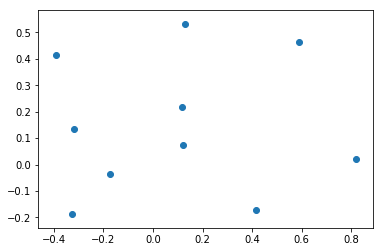

In [21]:
plt.scatter(x,y)

In [22]:
num_ratings_vs_movies = [0 for i in movie_dic.keys()]
for (i, j, yij) in lst:
    num_ratings_vs_movies[j] += 1
num_ratings_vs_movies = np.array(num_ratings_vs_movies)

In [23]:
indices = num_ratings_vs_movies.argsort()[-10:][::-1]

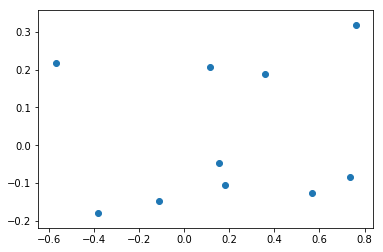

In [24]:
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

In [25]:
movie_rating_dic = {id: [] for id in movie_dic.keys()} # dic of movie id and ratings

for rating in lst:
    _, movie_id, r = rating
    movie_rating_dic[movie_id].append(r)

avg_ratings = {movie: sum(movie_rating_dic[movie]) / len(movie_rating_dic[movie]) \
               for movie in movie_rating_dic}

# get ten best movies that received highest average rating
top_10 = sorted(avg_ratings.items(), key=lambda tup: tup[1], reverse=True)[:10]
indices = [t[0] for t in top_10]

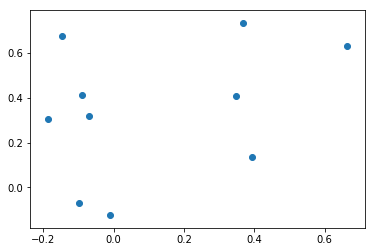

In [26]:
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

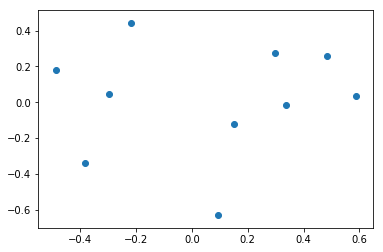

In [27]:
fant_movies = movie_genre_dic['Fantasy']
indices = fant_movies[:10]
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

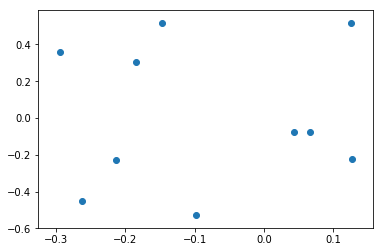

In [28]:
fant_movies = movie_genre_dic['Documentary']
indices = fant_movies[:10]
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

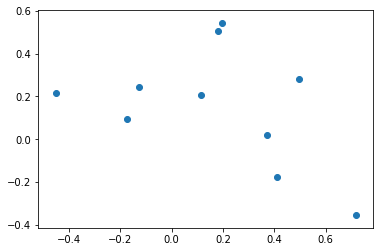

In [29]:
fant_movies = movie_genre_dic["Children's"]
indices = fant_movies[:10]
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)